### Import Dependencies

In [1]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 30 kB/s 
     |████████████████████████████████| 198 kB 55.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=7d740338921ae674e079a3db8e5e204dbc1081638d4d9ea263ecae8c185b2ebf
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime
import os

# Math operations
import numpy as np

# Random sampling
import random

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Keras API 
import tensorflow as tf
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal

# pyspark related
# pip install pyspark
import pyspark
from pyspark.sql.functions import split, explode, to_timestamp, from_unixtime, from_utc_timestamp
from pyspark import SparkConf, SparkContext,SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,ArrayType,StringType,DoubleType
from pyspark.sql.functions import *
from pyspark.sql import Window
# from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
#from ts.flint import FlintContext
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


### Data

#### Get Historic Data

In [3]:
%%bash
if [ ! -d '/content/data' ]; then
  git clone https://gitlab.com/Dimu_1020/big_data_final '/content/data'
  cd '/content/data'
else
  echo "Dataset already downloaded in '/content/data'"
fi

Cloning into '/content/data'...


In [4]:
spark = SparkSession.builder.appName("DataFrame").getOrCreate()
path_to_file = 'data/HistoryBulk_NY.csv'
df = spark.read.csv(path_to_file, header=True)
df.show()

+---------+--------------------+--------+---------+---------+----------+------+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+--------------------+------------+
|       dt|              dt_iso|timezone|city_name|      lat|       lon|  temp|feels_like|temp_min|temp_max|pressure|sea_level|grnd_level|humidity|wind_speed|wind_deg|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main| weather_description|weather_icon|
+---------+--------------------+--------+---------+---------+----------+------+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+--------------------+------------+
|283996800|1979-01-01 00:00:...|  -18000| New York|40.712775|-74.005973|280.34|    276.58|  280.33|  280.35|    1030|     null|      null|      93|       6.7|     170|   null|   null|   null|  

#### Pre-processing

In [5]:
# convert to datestamp
spark.conf.set('spark.sql.session.timeZone', 'UTC')
df = df.withColumn("dt",from_unixtime(unix_timestamp(col("dt_iso"),"yyyy-MM-dd HH:mm:ss '+0000 UTC'"),'yyyy-MM-dd HH:mm:ss').cast("timestamp"))
# Sorting by the date 
df = df.sort(asc("dt"))
df.show()

+-------------------+--------------------+--------+---------+---------+----------+------+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+--------------------+------------+
|                 dt|              dt_iso|timezone|city_name|      lat|       lon|  temp|feels_like|temp_min|temp_max|pressure|sea_level|grnd_level|humidity|wind_speed|wind_deg|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main| weather_description|weather_icon|
+-------------------+--------------------+--------+---------+---------+----------+------+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+--------------------+------------+
|1979-01-01 00:00:00|1979-01-01 00:00:...|  -18000| New York|40.712775|-74.005973|280.34|    276.58|  280.33|  280.35|    1030|     null|      null|      93|      

In [6]:
# Listing the min and the max dates
first = df.agg({'dt': "min"}).collect()[0][0] 
last = df.agg({'dt': "max"}).collect()[0][0]
print(f"First date {first}")
print(f"Most recent date {last}")

First date 1979-01-01 00:00:00
Most recent date 2021-12-11 23:00:00


In [7]:
df = df.withColumn("date",to_date("dt_iso"))
df.show()

+-------------------+--------------------+--------+---------+---------+----------+------+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+--------------------+------------+----------+
|                 dt|              dt_iso|timezone|city_name|      lat|       lon|  temp|feels_like|temp_min|temp_max|pressure|sea_level|grnd_level|humidity|wind_speed|wind_deg|rain_1h|rain_3h|snow_1h|snow_3h|clouds_all|weather_id|weather_main| weather_description|weather_icon|      date|
+-------------------+--------------------+--------+---------+---------+----------+------+----------+--------+--------+--------+---------+----------+--------+----------+--------+-------+-------+-------+-------+----------+----------+------------+--------------------+------------+----------+
|1979-01-01 00:00:00|1979-01-01 00:00:...|  -18000| New York|40.712775|-74.005973|280.34|    276.58|  280.33|  280.35|    1030|   

In [8]:
# Aggregating to hourly level
features = ['temp', 'pressure', 'wind_speed','Weather_main']
data_col = ['dt', 'date'] + features

df_data = df.select(data_col).withColumn("temp", avg("temp").over(Window.partitionBy("dt"))) \
                   .withColumn("pressure", avg("pressure").over(Window.partitionBy("dt"))) \
                   .withColumn("wind_speed", avg("wind_speed").over(Window.partitionBy("dt")))
df_data.show()

+-------------------+----------+------+--------+----------+------------+
|                 dt|      date|  temp|pressure|wind_speed|Weather_main|
+-------------------+----------+------+--------+----------+------------+
|1979-01-01 00:00:00|1979-01-01|280.34|  1030.0|       6.7|         Fog|
|1979-01-01 00:00:00|1979-01-01|280.34|  1030.0|       6.7|     Drizzle|
|1979-01-01 00:00:00|1979-01-01|280.34|  1030.0|       6.7|        Rain|
|1979-01-01 01:00:00|1979-01-01|280.34|  1030.0|       6.7|         Fog|
|1979-01-01 01:00:00|1979-01-01|280.34|  1030.0|       6.7|     Drizzle|
|1979-01-01 01:00:00|1979-01-01|280.34|  1030.0|       6.7|        Rain|
|1979-01-01 02:00:00|1979-01-01|280.51|  1029.0|       6.7|        Rain|
|1979-01-01 03:00:00|1979-01-01|281.34|  1029.0|       5.2|        Rain|
|1979-01-01 04:00:00|1979-01-01|281.34|  1029.0|       5.2|        Rain|
|1979-01-01 05:00:00|1979-01-01|281.51|  1026.0|      5.67|      Clouds|
|1979-01-01 06:00:00|1979-01-01|281.91|  1026.0|   

### Feature Selection

In [9]:
# get integer timestamp
df_data = df_data.withColumn('timestamp',unix_timestamp(col('dt'), format='yyyy-MM-dd HH:mm:ss').alias('unix_timestamp'))

# Seconds in day 
SECOND = 24 * 60 * 60 

# Seconds in year 
YEAR = (365.25) * SECOND

features_final = ['temp', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'pressure', 'wind_speed', 'weather_main']
df_final = df_data.withColumn('hour', hour(df_data.dt)) \
       .withColumn('month', month(df_data.dt)) \
       .withColumn('day_cos', cos(col('hour') * (2 * np.pi / 24))) \
       .withColumn('day_sin', sin(col('hour') * (2 * np.pi /24))) \
       .withColumn('month_cos', cos(col('timestamp') * (2 * np.pi /YEAR))) \
       .withColumn('month_sin', sin(col('timestamp') * (2 * np.pi /YEAR))) \
       .select(features_final)
df_final.show()

+------+--------------------+--------------------+--------------------+------------------+--------+----------+------------+
|  temp|             day_cos|             day_sin|           month_sin|         month_cos|pressure|wind_speed|weather_main|
+------+--------------------+--------------------+--------------------+------------------+--------+----------+------------+
|280.34|                 1.0|                 0.0|-0.00430059270297...|0.9999907524084426|  1030.0|       6.7|         Fog|
|280.34|                 1.0|                 0.0|-0.00430059270297...|0.9999907524084426|  1030.0|       6.7|     Drizzle|
|280.34|                 1.0|                 0.0|-0.00430059270297...|0.9999907524084426|  1030.0|       6.7|        Rain|
|280.34|  0.9659258262890683| 0.25881904510252074|-0.00358383062804...|0.9999935780583941|  1030.0|       6.7|         Fog|
|280.34|  0.9659258262890683| 0.25881904510252074|-0.00358383062804...|0.9999935780583941|  1030.0|       6.7|     Drizzle|
|280.34|

In [10]:
pd_final = df_final.toPandas()
sunny = pd_final.weather_main == 'Clear'
cloudy = pd_final.weather_main == 'Clouds'
windy = pd_final.weather_main.isin(['Squall',  'Tornado'])
foggy =  pd_final.weather_main.isin(['Mist', 'Haze', 'Dust', 'Fog', 'Smoke'])
rainy = pd_final.weather_main.isin(['Drizzle', 'Rain', 'Thunderstorm'])
snowy = pd_final.weather_main .isin(['Snow'])
pd_final['weather_main'] = pd_final['weather_main'].where(~sunny, 'sunny')
pd_final['weather_main'] = pd_final['weather_main'].where(~cloudy, 'cloudy')
pd_final['weather_main'] = pd_final['weather_main'].where(~windy, 'windy')
pd_final['weather_main'] = pd_final['weather_main'].where(~foggy, 'foggy')
pd_final['weather_main'] = pd_final['weather_main'].where(~rainy, 'rainy')
pd_final['weather_main'] = pd_final['weather_main'].where(~snowy, 'snowy')
conditions = [
    (pd_final['weather_main'] == 'sunny'),
    (pd_final['weather_main'] == 'cloudy'),
    (pd_final['weather_main'] == 'windy'),
    (pd_final['weather_main'] == 'foggy'),
    (pd_final['weather_main'] == 'rainy'),
    (pd_final['weather_main'] == 'snowy')
]
values = [0, 1, 2, 3, 4, 5]
pd_final['weather_id'] = np.select(conditions, values)

pd_final

,temp,day_cos,day_sin,month_sin,month_cos,pressure,wind_speed,weather_main,weather_id
0,280.34,1.000000,0.000000,-0.004301,0.999991,1030.0,6.70,foggy,3
1,280.34,1.000000,0.000000,-0.004301,0.999991,1030.0,6.70,rainy,4
2,280.34,1.000000,0.000000,-0.004301,0.999991,1030.0,6.70,rainy,4
3,280.34,0.965926,0.258819,-0.003584,0.999994,1030.0,6.70,foggy,3
4,280.34,0.965926,0.258819,-0.003584,0.999994,1030.0,6.70,rainy,4
...,...,...,...,...,...,...,...,...,...
416544,289.09,0.258819,-0.965926,-0.340673,0.940182,1004.0,0.45,cloudy,1
416545,289.64,0.500000,-0.866025,-0.339999,0.940426,1003.0,0.45,cloudy,1
416546,291.16,0.707107,-0.707107,-0.339325,0.940669,1003.0,0.89,cloudy,1
416547,291.23,0.866025,-0.500000,-0.338650,0.940912,1003.0,0.89,rainy,4


In [11]:
if not os.path.exists("/content/data/pd_final.pkl"):
    pd_final.to_pickle('/content/data/pd_final.pkl')
else:
    pd_final = pd.read_pickle("/content/data/pd_final.pkl")
pd_final

,temp,day_cos,day_sin,month_sin,month_cos,pressure,wind_speed,weather_main,weather_id
0,280.34,1.000000,0.000000,-0.004301,0.999991,1030.0,6.70,foggy,3
1,280.34,1.000000,0.000000,-0.004301,0.999991,1030.0,6.70,rainy,4
2,280.34,1.000000,0.000000,-0.004301,0.999991,1030.0,6.70,rainy,4
3,280.34,0.965926,0.258819,-0.003584,0.999994,1030.0,6.70,foggy,3
4,280.34,0.965926,0.258819,-0.003584,0.999994,1030.0,6.70,rainy,4
...,...,...,...,...,...,...,...,...,...
416544,289.09,0.258819,-0.965926,-0.340673,0.940182,1004.0,0.45,cloudy,1
416545,289.64,0.500000,-0.866025,-0.339999,0.940426,1003.0,0.45,cloudy,1
416546,291.16,0.707107,-0.707107,-0.339325,0.940669,1003.0,0.89,cloudy,1
416547,291.23,0.866025,-0.500000,-0.338650,0.940912,1003.0,0.89,rainy,4


#### Train model

In [12]:
# Share of obs in testing 
train_test_split_share = 0.1

# Number of lags (hours back) to use for models
lag = 48

# Steps ahead to forecast 
n_ahead = 1

In [13]:
scaler = StandardScaler()
np_final = scaler.fit_transform(pd_final[['temp', 'day_cos', 'day_sin', 'month_sin', 'month_cos', 'pressure',
       'wind_speed']])
# np_final.concat(pd_final['weather_id'])
np_final = np.append(np_final, pd_final['weather_id'].values.reshape(-1,1).astype('int'), axis=1)
np_final

array([[-0.58443288,  1.41866325, -0.00454466, ...,  1.64491449,
         1.06338435,  3.        ],
       [-0.58443288,  1.41866325, -0.00454466, ...,  1.64491449,
         1.06338435,  4.        ],
       [-0.58443288,  1.41866325, -0.00454466, ...,  1.64491449,
         1.06338435,  4.        ],
       ...,
       [ 0.54947565,  1.00498065, -1.00586154, ..., -1.67457372,
        -1.21522996,  1.        ],
       [ 0.55681148,  1.22943743, -0.71258262, ..., -1.67457372,
        -1.21522996,  4.        ],
       [ 0.57881894,  1.37053686, -0.37105207, ..., -1.79751773,
        -1.38779284,  1.        ]])

#### Convert to time series dataset

In [14]:
def create_X_Y(ts: np.array, _lag=48, n_ahead=1, target_index=0) -> tuple:
    """
    - ts: A time series dataframe in series form
    - lag: Number of lags (hours back) to use for models
    - n_ahead: Steps ahead to forecast 
    Using <lag> number of data: x_{i}, x_{i+1}, ...x_{i+lag-1} to predict <n_ahead>
    number of data x_{i+lag}, ..., x_{i+lag+n_ahead-1}
    Thus, X = x_{i}, x_{i+1}, ...x_{i+lag-1}
        , Y = x_{i+lag}, ..., x_{i+lag+n_ahead-1}
    """
    # Extract # of features and # of observations
    n_obs = ts.shape[0]
    n_features = ts.shape[1]
    
    # Creating placeholder lists
    X, Y = [], []

    # if we don't have enough obs to predict Y
    if n_obs - _lag <= 0:
        X.append(ts) # no label, only x
    else:
        for i in range(n_obs - _lag - n_ahead):
            Y.append(ts[(i + _lag):(i + _lag + n_ahead), target_index])
            X.append(ts[i:(i + _lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], _lag, n_features))

    return X, Y
X, Y = create_X_Y(np_final, 48, n_ahead=n_ahead, target_index = 7)

In [15]:
# # Subseting only the needed columns 
# ts = pd_final

# nrows = ts.shape[0]

# # Spliting into train and test sets
# test_share = 0.25
# train = ts[0:int(nrows * (1 - test_share))]
# test = ts[int(nrows * (1 - test_share)):]

# # Creating the final scaled frame 
# ts_s = pd.concat([train, test])
# X, Y = create_X_Y(ts_s.values,n_ahead=n_ahead)

n_ft = X.shape[2]

# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - 0.25))], Y[0:int(X.shape[0] * (1 - 0.25))]
X_val, Y_val = X[int(X.shape[0] * (1 - 0.25)):], Y[int(X.shape[0] * (1 - 0.25)):]
Ytrain = Ytrain.astype('int')
Y_val= Y_val.astype('int')

#### LSTM

In [16]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(optimizer=optimizer,
                            loss=losses.MeanAbsoluteError(), 
                            # loss=tf.keras.losses.CategoricalCrossentropy(),
                            metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

model = NNMultistepModel(
    X=Xtrain,
    Y=Ytrain,
    n_outputs=n_ahead,
    n_lag=lag,
    n_ft=n_ft,
    n_layer=10,
    batch=512,
    epochs=20, 
    lr=0.001,
    Xval=X_val,
    Yval=Y_val,
)

In [17]:
model.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 10)                760       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.train()

Epoch 1/20
611/611 [==============================] - 26s 40ms/step - loss: 0.7305 - sparse_categorical_accuracy: 0.2462 - val_loss: 0.6160 - val_sparse_categorical_accuracy: 0.4293
Epoch 2/20
611/611 [==============================] - 25s 41ms/step - loss: 0.4872 - sparse_categorical_accuracy: 0.2462 - val_loss: 0.5712 - val_sparse_categorical_accuracy: 0.4293
Epoch 3/20
611/611 [==============================] - 23s 37ms/step - loss: 0.4581 - sparse_categorical_accuracy: 0.2462 - val_loss: 0.5471 - val_sparse_categorical_accuracy: 0.4293
Epoch 4/20
611/611 [==============================] - 23s 37ms/step - loss: 0.4482 - sparse_categorical_accuracy: 0.2462 - val_loss: 0.5438 - val_sparse_categorical_accuracy: 0.4293
Epoch 5/20
611/611 [==============================] - 22s 36ms/step - loss: 0.4424 - sparse_categorical_accuracy: 0.2462 - val_loss: 0.5440 - val_sparse_categorical_accuracy: 0.4293
Epoch 6/20
611/611 [==============================] - 22s 36ms/step - loss: 0.4383 - spars

Text(0.5, 1.0, 'Loss of LSTM model')

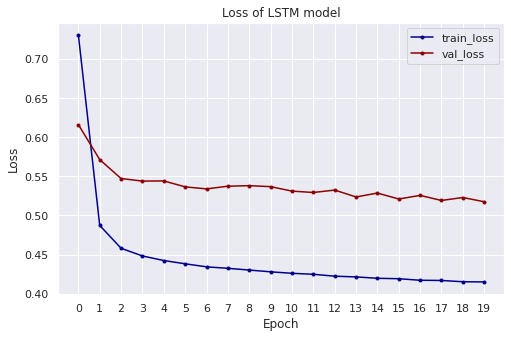

In [19]:
sns.set()
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
n_epochs = range(len(loss))

fig = plt.figure(figsize = (8, 5))
plt.plot(loss, '.-', 
         label='train_loss', color = 'darkblue')
plt.plot(val_loss, '.-',
         label = 'val_loss', color = 'darkred')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 20, 1))
plt.legend(loc='upper right')
plt.title('Loss of LSTM model')

In [20]:
# import pickle
# filename = 'NNMultistepModel_lstm_model.sav'
# pickle.dump(model, open(filename, 'wb'))

In [21]:
# # some time later...
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = model.predict(X_val)
# print(np.around(result).astype(np.uint64))

In [22]:
model.model.save("NNMultistepModel_lstm_model.h5")

In [23]:
from google.colab import files
files.download("/content/NNMultistepModel_lstm_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>